In [163]:
import gymnasium as gym
import grid2op
from grid2op import gym_compat
from grid2op.Parameters import Parameters
from grid2op.Action import PlayableAction
from grid2op.Observation import CompleteObservation
from grid2op.Reward import L2RPNReward, N1Reward, CombinedScaledReward

from lightsim2grid import LightSimBackend
import numpy as np
from gymnasium.spaces import Box, Discrete

import matplotlib.pyplot as plt
from stable_baselines3 import DQN

from numpy import inf

In [164]:
print(grid2op.__version__)

1.10.5


- #### `Initialise` the environment

In [356]:
class Gym2OpEnv(gym.Env):
    def __init__(self):
        super().__init__()

        self._backend = LightSimBackend()
        self._env_name = "l2rpn_case14_sandbox"  # DO NOT CHANGE

        action_class = PlayableAction
        observation_class = CompleteObservation
        reward_class = CombinedScaledReward

        # DO NOT CHANGE Parameters
        p = Parameters()
        p.MAX_SUB_CHANGED = 4
        p.MAX_LINE_STATUS_CHANGED = 4

        # Make grid2op env
        self._g2op_env = grid2op.make(
            self._env_name,
            backend=self._backend,
            test=False,
            action_class=action_class,
            observation_class=observation_class,
            reward_class=reward_class,
            param=p,
        )

        # Set combined reward
        cr = self._g2op_env.get_reward_instance()
        cr.addReward("N1", N1Reward(), 1.0)
        cr.addReward("L2RPN", L2RPNReward(), 1.0)
        cr.initialize(self._g2op_env)
        self._g2op_env.change_reward(cr)

        self._gym_env = gym_compat.GymEnv(self._g2op_env)

        self.relevantObservations = [
        "hour_of_day"
        ,"minute_of_hour"
        ,"gen_p"
        ,"gen_q"
        ,"gen_v"
        ,"gen_theta"
        ,"load_p"
        ,"load_q"
        ,"load_v"
        ,"load_theta"
        ,"p_or"
        ,"q_or"
        ,"v_or"
        ,"a_or"
        ,"p_ex"
        ,"v_ex"
        ,"a_ex"
        ,"rho"
        ,"line_status"
        ,"topo_vect"
        ,"time_next_maintenance"
        ,"target_dispatch"
        ,"actual_dispatch"
        ,"current_step"
        ,"max_step" 
        ]

        self.setup_observations()
        self.setup_actions()

    def setup_observations(self):
        # Flatten the observation space
        sample_obs, _ = self._gym_env.reset()
        min_obs = {}
        # for observation in self.relevantObservations:
        #     min_obs[observation] = sample_obs[observation]
        # print("MIn obs:",min_obs)
        # flat_obs = self.flatten_observation(min_obs)
        # flat_obs = self.flatten_observation(sample_obs)
        # obs_size = flat_obs.shape[0]
        for observation in self.relevantObservations:
            min_obs[observation] = np.array([sample_obs[observation]], dtype=int)
        
        self.observation_space = gym.spaces.Dict({
                "hour_of_day": gym.spaces.Box(low=0, high=np.inf, shape=(1,), dtype=int),
                "minute_of_hour": gym.spaces.Box(low=0, high=np.inf, shape=(1,), dtype=int),
                "gen_p": gym.spaces.Box(low=0, high=np.inf, shape=(6,), dtype=int),
                "gen_q": gym.spaces.Box(low=0, high=np.inf, shape=(6,), dtype=int),
                "gen_v": gym.spaces.Box(low=0, high=np.inf, shape=(6,), dtype=int),
                "gen_theta": gym.spaces.Box(low=0, high=np.inf, shape=(6,), dtype=int),
                "load_p": gym.spaces.Box(low=0, high=np.inf, shape=(11,), dtype=int),
                "load_q": gym.spaces.Box(low=0, high=np.inf, shape=(11,), dtype=int),
                "load_v": gym.spaces.Box(low=0, high=np.inf, shape=(11,), dtype=int),
                "load_theta": gym.spaces.Box(low=0, high=np.inf, shape=(11,), dtype=int),
                "p_or": gym.spaces.Box(low=0, high=np.inf, shape=(20,), dtype=int),
                "q_or": gym.spaces.Box(low=0, high=np.inf, shape=(20,), dtype=int),
                "v_or": gym.spaces.Box(low=0, high=np.inf, shape=(20,), dtype=int),
                "a_or": gym.spaces.Box(low=0, high=np.inf, shape=(20,), dtype=int),
                "p_ex": gym.spaces.Box(low=0, high=np.inf, shape=(20,), dtype=int),
                "v_ex": gym.spaces.Box(low=0, high=np.inf, shape=(20,), dtype=int),
                "a_ex": gym.spaces.Box(low=0, high=np.inf, shape=(20,), dtype=int),
                "rho": gym.spaces.Box(low=0, high=np.inf, shape=(20,), dtype=int),
                "line_status": gym.spaces.Box(low=0, high=np.inf, shape=(20,), dtype=int),
                "topo_vect": gym.spaces.Box(low=0, high=np.inf, shape=(57,), dtype=int),
                "time_next_maintenance": gym.spaces.Box(low=0, high=np.inf, shape=(20,), dtype=int),
                "target_dispatch": gym.spaces.Box(low=0, high=np.inf, shape=(6,), dtype=int),
                "actual_dispatch": gym.spaces.Box(low=0, high=np.inf, shape=(6,), dtype=int),
                "current_step": gym.spaces.Box(low=0, high=np.inf, shape=(20,), dtype=int),
                "max_step" : gym.spaces.Box(low=0, high=np.inf, shape=(20,), dtype=int),})
        # self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(obs_size,), dtype=np.float32)

    def setup_actions(self):
        self.available_actions = []
        num_powerlines =10
        num_generators = 6
        num_sub_stations = 16

        # Get the action space from the Grid2Op environment
        action_space = self._g2op_env.action_space

        # Define discrete actions
        # Action 0: Do nothing
        no_op = action_space({})
        gym_no_op = self._gym_env.action_space.to_gym(no_op)
        self.available_actions.append(gym_no_op)

        #Open and Close all powerlines
        for line in range(num_powerlines):
            close_line = action_space({"set_line_status":[(line,-1)]})
            gym_close_line = self._gym_env.action_space.to_gym(close_line)
            open_line = action_space({"set_line_status":[(line,1)]})
            gym_open_line = self._gym_env.action_space.to_gym(open_line)
            self.available_actions.append(gym_close_line)
            self.available_actions.append(gym_open_line)

        # Redispatch all generators
        for generator in range(num_generators):
            redispatch_gen = action_space({"redispatch":[(generator,2.5)]})
            gym_redispatch_gen = self._gym_env.action_space.to_gym(redispatch_gen)
            self.available_actions.append(gym_redispatch_gen)


        # Add more actions as needed
        # For example, open/close other lines
        # Valid keys are {'change_line_status', 'set_bus', 'set_storage', 'change_bus', 'raise_alert', 'raise_alarm', 'curtail', 'redispatch'}

        # Update the action space to Discrete
        self.action_space = gym.spaces.Discrete(len(self.available_actions))
        # self.action_space = gym.spaces.Box()

    def reset(self, seed=None):
        obs, info = self._gym_env.reset(seed=seed, options=None)
        min_obs = {}
        # for observation in self.relevantObservations:
        #     min_obs[observation] = obs[observation]
        for observation in self.relevantObservations:
            min_obs[observation] = np.array([obs[observation]], dtype=int)
        # print("MIn obs:",min_obs)
        # print(len(min_obs))
        # obs = self.flatten_observation(min_obs)
        # obs = self.flatten_observation(obs)
        # return obs, info
        return min_obs, info

    def step(self, action):
        # Retrieve the Gym-formatted action
        gym_action = self.available_actions[action]

        # Pass the action to the environment
        obs, reward, terminated, truncated, info = self._gym_env.step(gym_action)
        # print("Steps obs:",obs)
        min_obs = {}
        for observation in self.relevantObservations:
            min_obs[observation] = np.array([obs[observation]], dtype=int)
        # for observation in self.relevantObservations:
        #     min_obs[observation] = obs[observation]
        # print("MIn obs:",min_obs)
        # print(len(min_obs))
        # obs = self.flatten_observation(min_obs)
       
        # obs = self.flatten_observation(obs)

        # Extract individual rewards
        reward_components = info.get('reward_detail', {})
        info['reward_components'] = reward_components

        # return obs, reward, terminated, truncated, info
        return min_obs, reward, terminated, truncated, info

    def render(self):
        return self._gym_env.render()

    def flatten_observation(self, obs):
        obs_list = []
        for key in sorted(obs.keys()):
            obs_component = np.array(obs[key]).flatten()
            obs_list.append(obs_component)
        flat_obs = np.concatenate(obs_list).astype(np.float32)
        return flat_obs

- #### `Test` the environment

In [352]:
def test_environment():
    env = Gym2OpEnv()
    obs, info = env.reset()
    # print("Initial observation shape:", obs.shape)
    # print("Initial observation:", obs)

    for _ in range(5):
        action = env.action_space.sample()
        obs, reward, terminated, truncated, info = env.step(action)
        print("Step result:")
        print("Action taken:", action)
        # print("Observation shape:", obs.shape)
        # print("Num observations: ", obs.shape)
        print("Reward:", reward)
        print("Terminated:", terminated)
        if terminated or truncated:
            obs, info = env.reset()

if __name__ == "__main__":
    test_environment()

c:\Users\widas\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\dtypes\cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Step result:
Action taken: 3
Reward: 0.19854684174060822
Terminated: False
Step result:
Action taken: 0
Reward: 0.19878768920898438
Terminated: False
Step result:
Action taken: 21
Reward: 0.19379492104053497
Terminated: False
Step result:
Action taken: 14
Reward: 0.19689121842384338
Terminated: False
Step result:
Action taken: 4
Reward: 0.34786683320999146
Terminated: False


-  #### `Print` observation space and action space

In [337]:
def test_environment():
    env = Gym2OpEnv()

    # Print the action and observation spaces
    print("Action space:", env.action_space)
    print("Number of actions:", env.action_space.n)
    print("Observation space:", env.observation_space)
    print("Observation shape:", env.observation_space.shape)

    obs, info = env.reset()
    # print("Initial observation shape:", obs.shape)
    # print("Initial observation:", obs)

    # Sample a random action
    action = env.action_space.sample()
    print("Sampled action index:", action)
    print("Corresponding action:", env.available_actions[action])

    # Take a step
    obs, reward, terminated, truncated, info = env.step(action)
    # print("Observation after action:", obs)
    print("Reward received:", reward)
    print("Terminated:", terminated)
    print("Truncated:", truncated)
    print("Info:", info)

In [338]:
test_environment()

c:\Users\widas\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\dtypes\cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Action space: Discrete(27)
Number of actions: 27
Observation space: Dict('a_ex': Box(0, 2147483645, (1,), int32), 'a_or': Box(0, 2147483645, (1,), int32), 'actual_dispatch': Box(0, 2147483645, (1,), int32), 'current_step': Box(0, 2147483645, (1,), int32), 'gen_p': Box(0, 2147483645, (1,), int32), 'gen_q': Box(0, 2147483645, (1,), int32), 'gen_theta': Box(0, 2147483645, (1,), int32), 'gen_v': Box(0, 2147483645, (1,), int32), 'hour_of_day': Box(0, 2147483645, (1,), int32), 'line_status': Box(0, 2147483645, (1,), int32), 'load_p': Box(0, 2147483645, (1,), int32), 'load_q': Box(0, 2147483645, (1,), int32), 'load_theta': Box(0, 2147483645, (1,), int32), 'load_v': Box(0, 2147483645, (1,), int32), 'max_step': Box(0, 2147483645, (1,), int32), 'minute_of_hour': Box(0, 2147483645, (1,), int32), 'p_ex': Box(0, 2147483645, (1,), int32), 'p_or': Box(0, 2147483645, (1,), int32), 'q_or': Box(0, 2147483645, (1,), int32), 'rho': Box(0, 2147483645, (1,), int32), 'target_dispatch': Box(0, 2147483645, (1,

- #### `Test` the environment

In [339]:
def main():
    max_steps = 100
    env = Gym2OpEnv()

    print("#####################")
    print("# OBSERVATION SPACE #")
    print("#####################")
    print(env.observation_space)
    print("#####################\n")

    print("#####################")
    print("#   ACTION SPACE    #")
    print("#####################")
    print(env.action_space)
    print("#####################\n\n")

    curr_step = 0
    curr_return = 0

    is_done = False
    obs, info = env.reset()
    print(f"step = {curr_step} (reset):")
    print(f"\t obs = {obs}")
    print(f"\t info = {info}\n\n")

    while not is_done and curr_step < max_steps:
        # Random action
        action = env.action_space.sample()
        obs, reward, terminated, truncated, info = env.step(action)

        curr_step += 1
        curr_return += reward
        is_done = terminated or truncated

        print(f"step = {curr_step}: ")
        # print(f"\t obs = {obs}")
        print(f"\t reward = {reward}")
        print(f"\t terminated = {terminated}")
        print(f"\t truncated = {truncated}")
        print(f"\t info = {info}")

        # Checking if action is valid
        is_action_valid = not (info["is_illegal"] or info["is_ambiguous"])
        print(f"\t is action valid = {is_action_valid}")
        if not is_action_valid:
            print(f"\t\t reason = {info['exception']}")
        print("\n")

    print("###########")
    print("# SUMMARY #")
    print("###########")
    print(f"return = {curr_return}")
    print(f"total steps = {curr_step}")
    print("###########")

if __name__ == "__main__":
    main()

c:\Users\widas\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\dtypes\cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


#####################
# OBSERVATION SPACE #
#####################
Dict('a_ex': Box(0, 2147483645, (1,), int32), 'a_or': Box(0, 2147483645, (1,), int32), 'actual_dispatch': Box(0, 2147483645, (1,), int32), 'current_step': Box(0, 2147483645, (1,), int32), 'gen_p': Box(0, 2147483645, (1,), int32), 'gen_q': Box(0, 2147483645, (1,), int32), 'gen_theta': Box(0, 2147483645, (1,), int32), 'gen_v': Box(0, 2147483645, (1,), int32), 'hour_of_day': Box(0, 2147483645, (1,), int32), 'line_status': Box(0, 2147483645, (1,), int32), 'load_p': Box(0, 2147483645, (1,), int32), 'load_q': Box(0, 2147483645, (1,), int32), 'load_theta': Box(0, 2147483645, (1,), int32), 'load_v': Box(0, 2147483645, (1,), int32), 'max_step': Box(0, 2147483645, (1,), int32), 'minute_of_hour': Box(0, 2147483645, (1,), int32), 'p_ex': Box(0, 2147483645, (1,), int32), 'p_or': Box(0, 2147483645, (1,), int32), 'q_or': Box(0, 2147483645, (1,), int32), 'rho': Box(0, 2147483645, (1,), int32), 'target_dispatch': Box(0, 2147483645, (1,),

c:\Users\widas\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\dtypes\cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 8.25     |
|    ep_rew_mean      | 1.66     |
|    exploration_rate | 0.969    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 63       |
|    time_elapsed     | 0        |
|    total_timesteps  | 33       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 7.75     |
|    ep_rew_mean      | 1.37     |
|    exploration_rate | 0.941    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 65       |
|    time_elapsed     | 0        |
|    total_timesteps  | 62       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 7.25     |
|    ep_rew_mean      | 1.2    

c:\Users\widas\AppData\Local\Programs\Python\Python312\Lib\site-packages\grid2op\Environment\environment.py:1415: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  rgb_array = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8).reshape(self._viewer.height, self._viewer.width, 3)
c:\Users\widas\AppData\Local\Programs\Python\Python312\Lib\site-packages\grid2op\Environment\environment.py:1415: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  rgb_array = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8).reshape(self._viewer.height, self._viewer.width, 3)
c:\Users\widas\AppData\Local\Programs\Python\Python312\Lib\site-packages\grid2op\Environment\environment.py:1415: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and

Episode finished after 14 timesteps


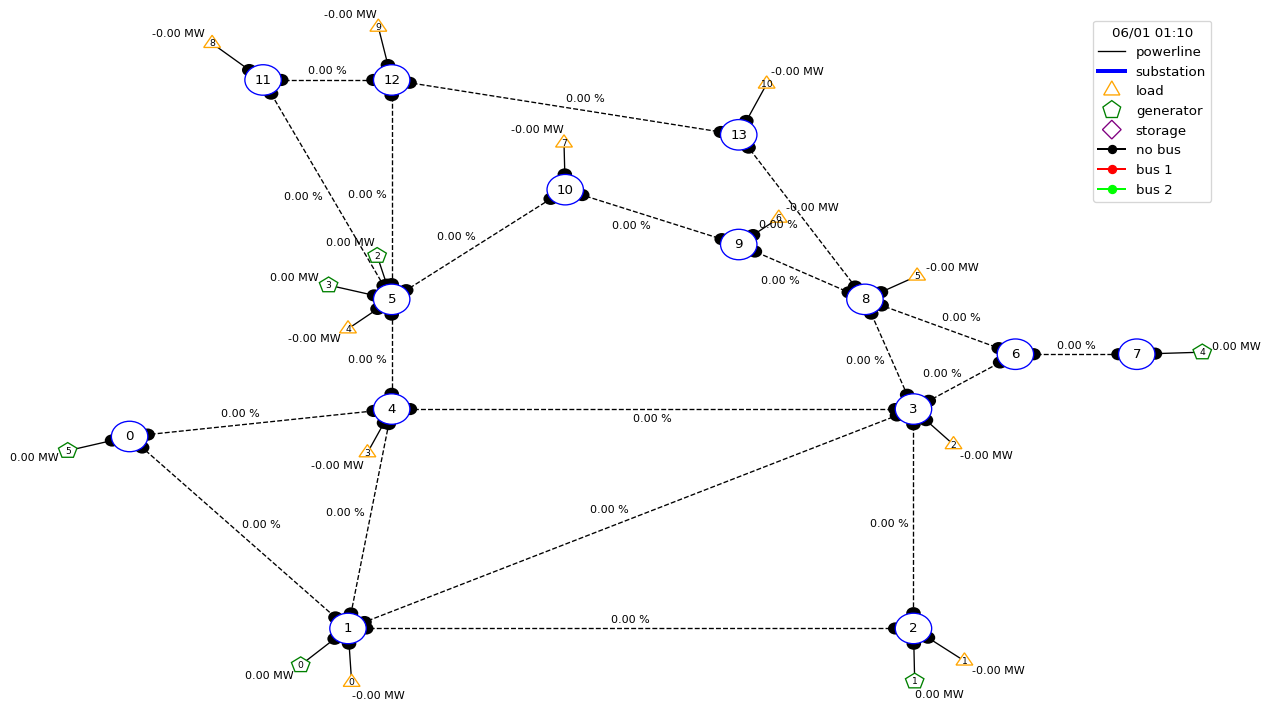

In [285]:
def train_dqn_agent():
    env = Gym2OpEnv()
    model = DQN("MlpPolicy", env, verbose=1)
    model.learn(total_timesteps=10000)
    model.save("dqn_grid2op_agent")

    # Evaluate the trained model
    obs, _ = env.reset()
    for step in range(100):
        action, _states = model.predict(obs)
        obs, reward, done, truncated, info = env.step(action)
        env.render()
        if done:
            print("Episode finished after {} timesteps".format(step + 1))
            break

if __name__ == "__main__":
    train_dqn_agent()

- #### `Evaluate` the environment

In [264]:
def evaluate_agent(model, env, num_episodes=10):
    episode_rewards = []
    reward_sum  =0
    for episode in range(num_episodes):
        obs, _ = env.reset()
        done = False
        total_reward = 0
        while not done:
            action, _states = model.predict(obs, deterministic=True)
            obs, reward, done, _, info = env.step(action)
            total_reward += reward
        episode_rewards.append(total_reward)
        print(f"Episode {episode + 1}: Total Reward = {total_reward}")
        reward_sum+=total_reward
    print(f"Average Reward:",reward_sum/num_episodes)
    return episode_rewards

- #### `Run` the evaluation function

In [286]:
if __name__ == "__main__":
    # Initialize the environment and model
    env = Gym2OpEnv()
    model = DQN("MlpPolicy", env, verbose=1)
    
    # Train the model
    #model.learn(total_timesteps=10000)
    #model.save("dqn_grid2op_agent")
    
    # Load the trained model (optional)
    model = DQN.load("dqn_grid2op_agent", env=env)
    
    # Evaluate the trained model
    num_evaluation_episodes = 100
    rewards = evaluate_agent(model, env, num_episodes=num_evaluation_episodes)

c:\Users\widas\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\dtypes\cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
c:\Users\widas\AppData\Local\Programs\Python\Python312\Lib\site-packages\grid2op\Observation\baseObservation.py:4056: RuntimeWarning: invalid value encountered in multiply
  res = 1.0 * self._thermal_limit


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Episode 1: Total Reward = 1.3814004212617874
Episode 2: Total Reward = 2.520154818892479
Episode 3: Total Reward = 0.9249646365642548
Episode 4: Total Reward = 10.478857159614563
Episode 5: Total Reward = 4.318220101296902
Episode 6: Total Reward = 8.39375326037407
Episode 7: Total Reward = 3.0759977102279663
Episode 8: Total Reward = 1.6140517592430115
Episode 9: Total Reward = 8.01810097694397
Episode 10: Total Reward = 3.260342925786972
Episode 11: Total Reward = 2.6775987669825554
Episode 12: Total Reward = 2.732175797224045
Episode 13: Total Reward = 4.593670047819614
Episode 14: Total Reward = 3.9373539239168167
Episode 15: Total Reward = 4.103696510195732
Episode 16: Total Reward = 0.6422380059957504
Episode 17: Total Reward = 15.930904597043991
Episode 18: Total Reward = 7.4130543395876884
Episode 19: Total Re

In [321]:
from stable_baselines3 import HerReplayBuffer, DDPG, SAC, TD3
from stable_baselines3.her.goal_selection_strategy import GoalSelectionStrategy
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise

In [357]:
if __name__ == "__main__":
    # Initialize the environment and model
    env = Gym2OpEnv()
    # env = gym.make("CartPole-v1")

    model_class = DQN
    goal_selection_strategy = "future"
    model = DQN('MultiInputPolicy', env, replay_buffer_class=HerReplayBuffer,replay_buffer_kwargs=dict(n_sampled_goal = 4,goal_selection_strategy=goal_selection_strategy),verbose=1)
    
    # Train the model
    model.learn(total_timesteps=10000)
    model.save("dqn_grid2op_agent_replay")
    
    # Load the trained model (optional)
    model = DQN.load("dqn_grid2op_agent_replay", env=env)
    
    # Evaluate the trained model
    num_evaluation_episodes = 100
    rewards = evaluate_agent(model, env, num_episodes=num_evaluation_episodes)

# if __name__ == "__main__":
# #     # Initialize the environment and model
#     env = Gym2OpEnv()
#     n_actions = env.action_space.shape
#     action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))

#     model = DDPG("MlpPolicy", env, action_noise=action_noise, verbose=1)
#     model.learn(total_timesteps=10000, log_interval=10)
#     model.save("ddpg_pendulum")
#     vec_env = model.get_env()

#     model = DDPG.load("ddpg_pendulum")

#     # obs = vec_env.reset()
#     # Evaluate the trained model
#     num_evaluation_episodes = 100
#     rewards = evaluate_agent(model, env, num_episodes=num_evaluation_episodes)
 

c:\Users\widas\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\dtypes\cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


c:\Users\widas\AppData\Local\Programs\Python\Python312\Lib\site-packages\stable_baselines3\common\buffers.py:605: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 3.05GB > 2.58GB
  warnings.warn(


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 12.8     |
|    ep_rew_mean      | 3.01     |
|    exploration_rate | 0.952    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 46       |
|    time_elapsed     | 1        |
|    total_timesteps  | 51       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 11.8     |
|    ep_rew_mean      | 2.76     |
|    exploration_rate | 0.911    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 47       |
|    time_elapsed     | 1        |
|    total_timesteps  | 94       |
----------------------------------


KeyError: 'achieved_goal'

- #### `Visualise` the results

In [56]:
def plot_rewards(episode_rewards):
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, len(episode_rewards) + 1), episode_rewards, marker='o')
    plt.title('Agent Performance Over Episodes')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.grid(True)
    plt.show()


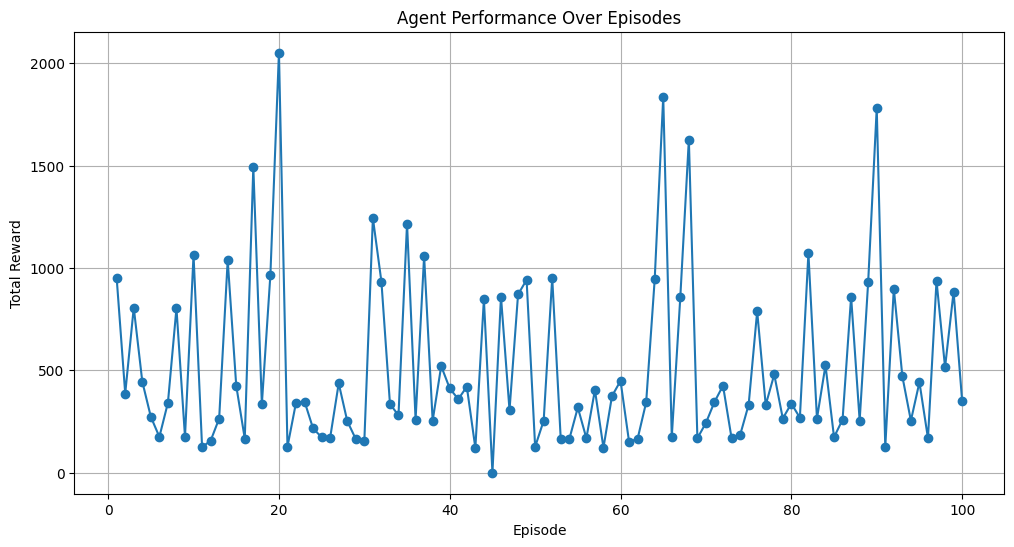

In [249]:
# call plot function
plot_rewards(rewards)

- #### `Extracting` individual reward components (L2RPN & N1)

In [86]:
def evaluate_agent(model, env, num_episodes=10):
    episode_rewards = []
    reward_components_list = []
    for episode in range(num_episodes):
        obs, _ = env.reset()
        done = False
        total_reward = 0
        episode_reward_components = {'L2RPN': 0.0, 'N1': 0.0}
        while not done:
            action, _states = model.predict(obs, deterministic=True)
            obs, reward, done, _, info = env.step(action)
            total_reward += reward
            # Accumulate reward components
            reward_components = info.get('reward_components', {})
            for key in episode_reward_components.keys():
                episode_reward_components[key] += reward_components.get(key, 0.0)
        episode_rewards.append(total_reward)
        reward_components_list.append(episode_reward_components)
        print(f"Episode {episode + 1}: Total Reward = {total_reward}")
        print(f"Reward Components: {episode_reward_components}")
        
    return episode_rewards, reward_components_list

In [87]:
# Call the Evaluate agent function
rewards, reward_components_list = evaluate_agent(model, env, num_episodes=num_evaluation_episodes)

Episode 1: Total Reward = 131.29422691464424
Reward Components: {'L2RPN': 0.0, 'N1': 0.0}
Episode 2: Total Reward = 176.23326900601387
Reward Components: {'L2RPN': 0.0, 'N1': 0.0}
Episode 3: Total Reward = 138.77094942331314
Reward Components: {'L2RPN': 0.0, 'N1': 0.0}
Episode 4: Total Reward = 220.7371575832367
Reward Components: {'L2RPN': 0.0, 'N1': 0.0}
Episode 5: Total Reward = 131.20245963335037
Reward Components: {'L2RPN': 0.0, 'N1': 0.0}
Episode 6: Total Reward = 133.86926700174809
Reward Components: {'L2RPN': 0.0, 'N1': 0.0}
Episode 7: Total Reward = 84.39300580322742
Reward Components: {'L2RPN': 0.0, 'N1': 0.0}
Episode 8: Total Reward = 51.943852841854095
Reward Components: {'L2RPN': 0.0, 'N1': 0.0}
Episode 9: Total Reward = 179.30641283094883
Reward Components: {'L2RPN': 0.0, 'N1': 0.0}
Episode 10: Total Reward = 49.146308213472366
Reward Components: {'L2RPN': 0.0, 'N1': 0.0}
Episode 11: Total Reward = 224.53727869689465
Reward Components: {'L2RPN': 0.0, 'N1': 0.0}
Episode 12

KeyboardInterrupt: 

- #### `Visualising` individual reward components (L2RPN & N1)

In [38]:
def plot_reward_components(reward_components_list):
    episodes = range(1, len(reward_components_list) + 1)
    l2rpn_rewards = [rc['L2RPN'] for rc in reward_components_list]
    n1_rewards = [rc['N1'] for rc in reward_components_list]
    
    plt.figure(figsize=(12, 6))
    plt.plot(episodes, l2rpn_rewards, label='L2RPN Reward', marker='o')
    plt.plot(episodes, n1_rewards, label='N1 Reward', marker='s')
    plt.title('Reward Components Over Episodes')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.legend()
    plt.grid(True)
    plt.show()

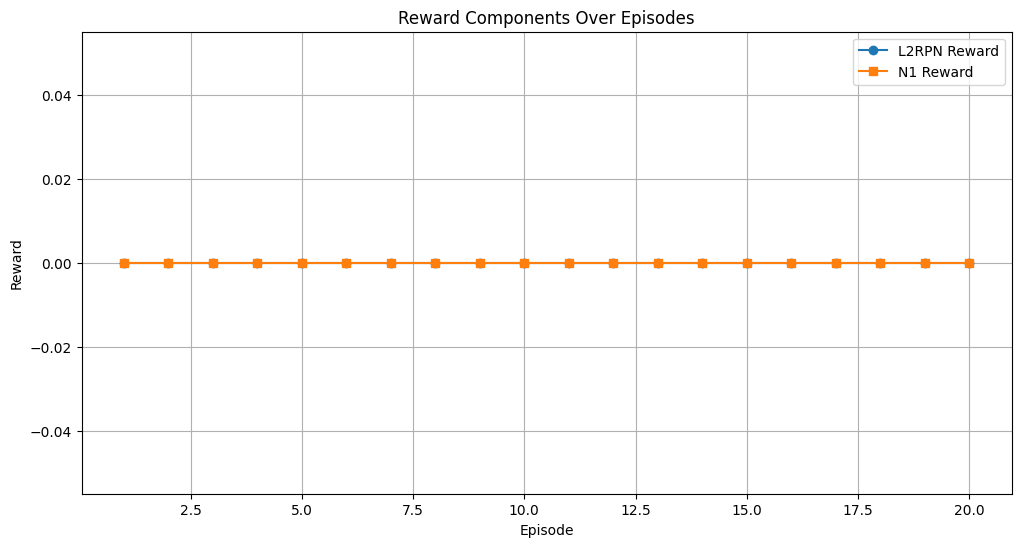

In [39]:
# Call the plot_reward_components
plot_reward_components(reward_components_list)